<center style="font-size:30px;padding-bottom:10px;color:DarkBlue;">Aplicaciones cuánticas con Pytorch y Qiskit</center>
<p>&nbsp;</p>
<center style="font-size:25px;padding-bottom:10px;color:CornFlowerBlue;">Creación de una CNN híbrida y circuitos hamiltonianos</center>
<p>&nbsp;</p>
<center style="font-size:18px;">María Barroso Honrubia</center>
<center style="font-size:18px;">Gloria del Valle Cano</center>

&nbsp;

En esta práctica vamos a investigar aplicaciones DL y algorítmicas de la computación cuántica. La motivación de esta entrega viene de la [Qiskit Hackaton Korea](https://www.hackerearth.com/challenges/hackathon/qiskit-hackathon-korea/), donde se han propuesto las aplicaciones que vamos a resolver. En la primera aplicación exploraremos cómo una red neuronal puede ser parcialmente cuantizada para crear una red neuronal cuántica clásica. Para ello, primero realizaremos el tutorial propuesto en [Hybrid quantum-classical Neural Networks with PyTorch and Qiskit](https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html), lo que nos servirá como aprendizaje para la ampliación de la red neuronal convolucional (CNN) que posteriormente crearemos para una clasificación multiclase. Después, investigaremos la aplicación a un problema NP-completo, encontrando una solución eficiente a un circuito hamiltoniano (HCP) a través del [algoritmo de Grover](https://es.wikipedia.org/wiki/Algoritmo_de_Grover).

In [2]:
from IPython.display import display, Math, Latex, HTML

## Tutorial de Qiskit

Para crear una red neuronal cuántica-clásica necesitamos implementar una capa oculta para la red neuronal usando un **circuito cuántico parametrizado**. Esto es un circuito donde los ángulos de rotación para cada puerta son especificados por las componentes de un vector clásico. Dicho de otra manera, están compuestos por puertas fijas (como podría ser una cNOT) y puertas cuya actuación depende de una variable ajustable como lo es una rotación cuántica de un ángulo determinado.

![Fig 1](img/hybridnetwork.png)

**Fig. 1.** Ilustra el framework que vamos a construir para clasificar los dígitos del popular dataset de [MNIST](http://yann.lecun.com/exdb/mnist/). Se intuye que es en la capa oculta de la red neuronal donde se construye el circuito cuántico, combinando las entradas y las salidas en Pytorch.

De esta forma, las salidas de capa anterior son recogidas y utilizadas como entradas del circuito parametrizado. Esto se muestra en la siguiente imagen.

![Fig 2](img/neuralnetworkQC.png)

**Fig. 2.** Se muestra el funcionamiento del circuito parametrizado en la capa oculta de la red neuronal. Aquí $\sigma$ es una función no lineal y $h_i$ es el valor de la neurona $i$ en cada capa oculta. $R(h_i)$ representa cualquier puerta rotatoria sobre un determinado ángulo igual a $h_i$, e $y$ es la predicción final de la red neural híbrida.

Además de esto tenemos que tener en cuenta qué hacemos para calcular los gradientes con circuitos cuánticos implicados. El cálculo se realiza con gradiente descencente, tomando el circuito cuántico como una caja negra de la siguiente manera:

![Fig 2.1](img/quantumgradient.png)

donde $\theta$ representa el parámetro del circuito cuántico y $s$ el desplazamiento macroscópico. Entonces el gradiente es simplemente la diferencia entre el circuito cuántico evaluado en $\theta+s$ y en $\theta-s$. Por tanto, podemos diferenciar sistemáticamente nuestro circuito cuántico como parte de una rutina de retropopagación más amplia. (Ver más en [Gradients of parameterizied quantum gates using the parameter-shift rule and gate decomposition](https://arxiv.org/pdf/1905.13311.pdf)).

### Codificación de una red neuronal híbrida

Primero importamos algunas librerías útiles de PyTorch y Qiskit.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

Ahora creamos una clase **QuantumCircuit** para el circuito cuántico con Qiskit. Especificamos el número de parámetros cuánticos entrenables y cuántos disparos deseamos utilizar. En este caso se va a utilizar un circuito simple de 1-qubit con un único parámetro entrenable, $\theta$, y una rotación $RY-$ por el ángulo $\theta$ para entrenar la salida del circuito. El circuito quedaría de la siguiente manera:

![Fig 3](img/1qubitcirc.png)

**Fig. 3.** Circuito cuántico diseñado.

Para poder medir la salida en base $z$, se calcula el valor esperado de la $\sigma_z$:

$$
\sigma_z = \sum_i z_i p(z_i)
$$

Codificamos ahora el circuito cuántico.

In [ ]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

Realizamos una prueba de la codificación para la rotación de $\theta = \pi$.

/opt/conda/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Expected value for rotation pi 0.54


/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


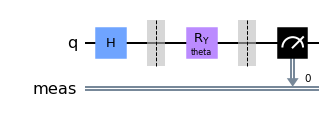

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Ahora que el circuito cuántico está creado, codificamos las clases que necesitamos para la retropopagación usando PyTorch con la fórmula anterior.

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

### Carga y preprocesamiento de datos

Definimos ahora los datos de train y los de test para el [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (dígitos de 0s y 1s).
Entrenamos la red neuronal híbrida creada con esta base de datos.

In [ ]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

Mostramos los resultados (por ejemplo, 10).

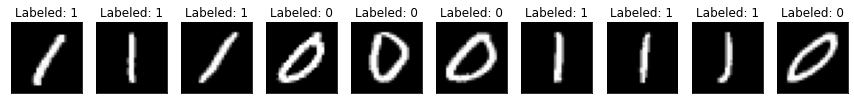

In [ ]:
n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

Guardamos ahora los datos de test.

In [ ]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Creación de la red neuronal híbrida

Creamos la red neuronal con PyTorch teniendo en cuenta que la capa cuántica debe ser reducible a 1 (que es el número de parámetros del circuito). Asimismo, creamos la red neuronal convolucional con dos capas totalmente conectadas hasta el final de manera que el valor de la última neurona se alimente del parámetro $\theta$.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Entrenamos la red neuronal con 20 épocas y con el optimizador Adam, con un $\eta=0.001$ y una función de pérdida *negative log-likelihood*.

/opt/conda/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)
/tmp/ipykernel_59/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8054
Training [10%]	Loss: -0.9095
Training [15%]	Loss: -0.9312
Training [20%]	Loss: -0.9488
Training [25%]	Loss: -0.9523
Training [30%]	Loss: -0.9590
Training [35%]	Loss: -0.9686
Training [40%]	Loss: -0.9679
Training [45%]	Loss: -0.9652
Training [50%]	Loss: -0.9665
Training [55%]	Loss: -0.9713
Training [60%]	Loss: -0.9711
Training [65%]	Loss: -0.9833
Training [70%]	Loss: -0.9785
Training [75%]	Loss: -0.9833
Training [80%]	Loss: -0.9838
Training [85%]	Loss: -0.9902
Training [90%]	Loss: -0.9904
Training [95%]	Loss: -0.9866
Training [100%]	Loss: -0.9895


Text(0, 0.5, 'Neg Log Likelihood Loss')

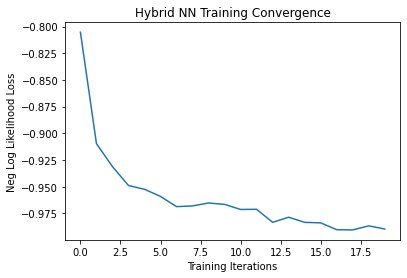

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Ahora probamos la red neuronal y mostramos ejemplos de predicción.

Performance on test data:
	Loss: -0.9769
	Accuracy: 100.0%


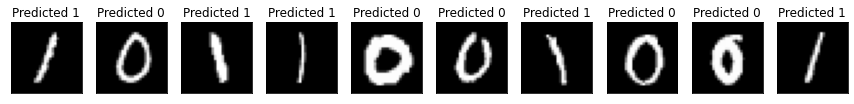

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

n_samples_show = 10
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

Observamos que el modelo ha tenido un 100% de accuracy. El tutorial nos ha hecho aprender a utilizar circuitos cuánticos dentro de una CNN simple, aunque no veamos las ventajas dada la simplicidad del ejemplo, ya que una CNN por sí misma es igual de capaz de predecir los dígitos. Si bien se puede ampliar para conseguir una mejora en otros ejemplos y poder ver los beneficios de utilizar CNN híbridas.

## Primera aplicación: CNN con clasificación multiclase

Creamos un modelo de clasificación multiclase para el mismo dataset para todos los dígitos (0-9) usando capas completamente conectadas. En las figuras de más abajo se muestra en mayor detalle los circuitos parametrizados utilizados así como la red neuronal en detalle.

![Fig 4](img/model1.png)

La capa cuántica se encuentra al final, justo antes de la salida.

![Fig 5](img/hybrid1.png)

Ya que esta parte la ejecutamos en Google Colab por la necesidad de GPU, realizamos las importaciones y las comprobaciones oportunas.

In [ ]:
use_cuda = torch.cuda.is_available()

print('CUDA available:', use_cuda)

if use_cuda:
    device = torch.device('cuda')
    print('Training on GPU...')
else:
    device = torch.device('cpu')
    print('Training on CPU...')


CUDA available: True
Training on GPU...


In [ ]:
# Enable your account on Qiskit, replace 'My_API_Token' with your newly generated token
qiskit.IBMQ.save_account('510db********mytoken')
# After loading credentials we query the backends
qiskit.IBMQ.load_account().backends()

/usr/local/lib/python3.7/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [ ]:
from qiskit.tools.jupyter import *
%qiskit_backend_overview

In [ ]:
# Show individual backend details
from qiskit.tools import backend_monitor
my_provider = qiskit.IBMQ.get_provider()
backend  = my_provider.get_backend('ibmq_manila')

Para esta CNN usamos el circuito cuántico creado previamente (**QuantumCircuit**) y la misma lógica de backpropagation explicada anteriormente (**HybridFunction**), pero es preciso adaptarla.

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z).cuda()
        
        ctx.save_for_backward(inputs, result)
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]).cuda() - torch.tensor([expectation_left]).cuda()
            gradients.append(gradient)
        
        # gradients = np.array([gradients]).T
        gradients = torch.tensor([gradients]).cuda()
        gradients = torch.transpose(gradients, 0, 1)

        # return torch.tensor([gradients]).float() * grad_output.float(), None, None
        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

Cogemos más muestras y tomamos un batch size de 256.

In [ ]:
n_samples = 512
batch_size = 256

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

X_train.data = X_train.data[:n_samples]
X_train.targets = X_train.targets[:n_samples]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



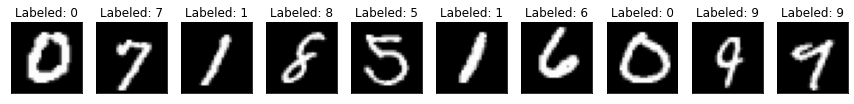

In [ ]:
# check MNIST data

n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 3))

images, targets = data_iter.__next__()

while n_samples_show > 0:
    axes[n_samples_show - 1].imshow(images[n_samples_show].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(int(targets[n_samples_show])))
    
    n_samples_show -= 1

In [ ]:
n_samples = 2048

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

X_test.data = X_test.data[:n_samples]
X_test.targets = X_test.targets[:n_samples]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

Definimos la CNN adaptando el diseño de la CNN ilustrada.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)
        # self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid = [Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2) for i in range(10)]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        # x = x.view(-1, 256)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.chunk(x, 10, dim=1)
        # x = self.hybrid(x)
        x = tuple([hy(x_) for hy, x_ in zip(self.hybrid, x)])
        return torch.cat(x, -1)

In [ ]:
from torchsummary import summary

Comprobamos que hemos creado correctamente la CNN.

In [ ]:
model = Net().cuda()

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
         Dropout2d-3             [-1, 16, 4, 4]               0
            Linear-4                   [-1, 64]          16,448
            Linear-5                   [-1, 10]             650
Total params: 19,670
Trainable params: 19,670
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.08
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  del sys.path[0]


Entrenamos la red neuronal con el mismo $\eta$ y 50 épocas.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_func = nn.NLLLoss() clasif multiclase
loss_func = nn.CrossEntropyLoss().cuda()

epochs = 50
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.cuda()
        target = target.cuda()
        
        # Forward pass
        output = model(data).cuda()

        # Calculating loss
        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [2%]	Loss: 2.3019
Training [4%]	Loss: 2.2973
Training [6%]	Loss: 2.2951
Training [8%]	Loss: 2.2874
Training [10%]	Loss: 2.2755
Training [12%]	Loss: 2.2621
Training [14%]	Loss: 2.2494
Training [16%]	Loss: 2.2256
Training [18%]	Loss: 2.2044
Training [20%]	Loss: 2.1820
Training [22%]	Loss: 2.1487
Training [24%]	Loss: 2.1181
Training [26%]	Loss: 2.0736
Training [28%]	Loss: 2.0241
Training [30%]	Loss: 1.9836
Training [32%]	Loss: 1.9500
Training [34%]	Loss: 1.9143
Training [36%]	Loss: 1.9054
Training [38%]	Loss: 1.8690
Training [40%]	Loss: 1.8659
Training [42%]	Loss: 1.8489
Training [44%]	Loss: 1.8271
Training [46%]	Loss: 1.8231
Training [48%]	Loss: 1.8054
Training [50%]	Loss: 1.8016
Training [52%]	Loss: 1.7896
Training [54%]	Loss: 1.7889
Training [56%]	Loss: 1.7757
Training [58%]	Loss: 1.7647
Training [60%]	Loss: 1.7632
Training [62%]	Loss: 1.7581
Training [64%]	Loss: 1.7508
Training [66%]	Loss: 1.7415
Training [68%]	Loss: 1.7392
Training [70%]	Loss: 1.7362
Training [72%]	Loss: 1.7

Text(0, 0.5, 'Neg Log Likelihood Loss')

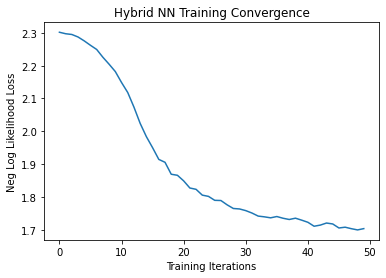

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        
        data = data.cuda()
        target = target.cuda()

        output = model(data).cuda()
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / batch_size)
        )

Performance on test data:
	Loss: 1.7257
	Accuracy: 81.4%


De esta manera hemos ampliado la clasificación binaria a todos los dígitos de la base de datos, consiguiendo una accuracy de 81.4\%. Es cierto que para este problema ya existen diferentes soluciones con una precisión mucho mayor, pero es verdad que esta es una de las más rápidas en entrenar. También hemos visto que las aplicaciones cuánticas pueden ser potenciales en temas de DL y su real utilidad se podría encontrar buscando soluciones más eficientes para la backpropagation, o realizando un mejor fine-tunning para la selección de parámetros e hiperparámetros.

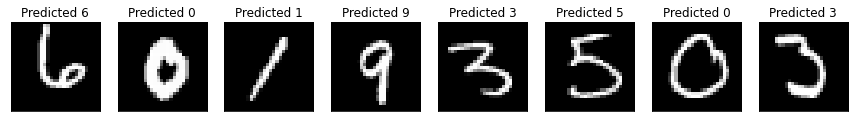

In [ ]:
n_samples_show = 8
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        
        data_cuda = data.cuda()
        target_cuda = target.cuda()

        output_cuda = model(data_cuda).cuda()
        
        pred = output_cuda.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[count].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred[count].item()))
        
        count += 1

### Segunda aplicación: Circuito Hamiltoniano con el Algoritmo de Grover
Recordando, un circuito hamiltoniano es aquel en el que el grafo resulta ser un camino que visita todos los vértices del grafo una sola vez.
Estudiaremos la propuesta del [equipo ganador](https://github.com/ho0-kim/Hamiltonian_Cycle_Problem_with_QC) de la Qiskit Hackaton Korea 2021, en la cual aplican el algoritmo de Grover. (Ver más información sobre el algoritmo [aquí](https://es.wikipedia.org/wiki/Algoritmo_de_Grover)).

Primero realizamos las importaciones oportunas y definimos el grafo así como su matriz de adyacencia.

In [1]:
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

![Grafo inicial](img/grafo_.png)

In [2]:
# Graph
g = np.array([[0,1,1,0,1,1],
              [1,0,1,0,0,0],
              [1,1,0,1,0,1],
              [0,0,1,0,1,1],
              [1,0,0,1,0,1],
              [1,0,1,1,1,0]])

Mostramos la información del grafo así como el número de iteraciones que tendremos que hacer con el algoritmo de Grover.

In [11]:
n_vertices = g.shape[0]
n_edges = 0
for i in range(n_vertices):
    n_edges += sum(g[i, i:])
# qubits = n(v) + n(e) + 1
# iteration sqrt(n(e)*pi/4)
iter = int(np.pi/(4*np.arcsin(1/np.sqrt(2**n_edges))) - 1/2)

print('Número de vértices:', n_vertices)
print('Número de aristas:', n_edges)
print('Qubits:', n_vertices + n_edges + 1)
print('Número de iteraciones (Grover):', iter)

Número de vértices: 6
Número de aristas: 10
Qubits: 17
Número de iteraciones (Grover): 24


Guardamos las relaciones con los nodos que unen.

In [4]:
g_dict = {} # {edge: [vertex1, vertex2]}

edge_idx = 0
for i in range(n_vertices):
    for j in range(i, n_vertices):
        if g[i,j] == 1:
            g_dict[edge_idx] = [i, j]
            edge_idx += 1
g_dict

{0: [0, 1],
 1: [0, 2],
 2: [0, 4],
 3: [0, 5],
 4: [1, 2],
 5: [2, 3],
 6: [2, 5],
 7: [3, 4],
 8: [3, 5],
 9: [4, 5]}

![Grover](img/grover1.png)

Computamos el algoritmo con la aplicación del oráculo y la inversión sobre la media.

In [5]:
def oracle(qc, qr_v, qr_e, qr_f, n_vertices):
    # encode
    for i in g_dict:
        qc.cry(np.pi/2, qr_e[i], g_dict[i][0])
        qc.cry(np.pi/2, qr_e[i], g_dict[i][1])
    qc.barrier()

    # set flag
    qc.mcx(v, flag)
    qc.barrier()

    # inverse
    for i in g_dict:
        qc.cry(-np.pi/2, qr_e[i], g_dict[i][0])
        qc.cry(-np.pi/2, qr_e[i], g_dict[i][1])
    qc.barrier()
    
def diffuser(qc, qr_e, ancilla):
    qc.h(qr_e)
    qc.x(qr_e)
    qc.h(qr_e[-1])
    qc.mct(qr_e[:-1], qr_e[-1])#, ancilla_qubits=ancilla)
    qc.h(qr_e[-1])
    qc.x(qr_e)
    qc.h(qr_e)

Diseñamos el circuito con la iteración de Grover.

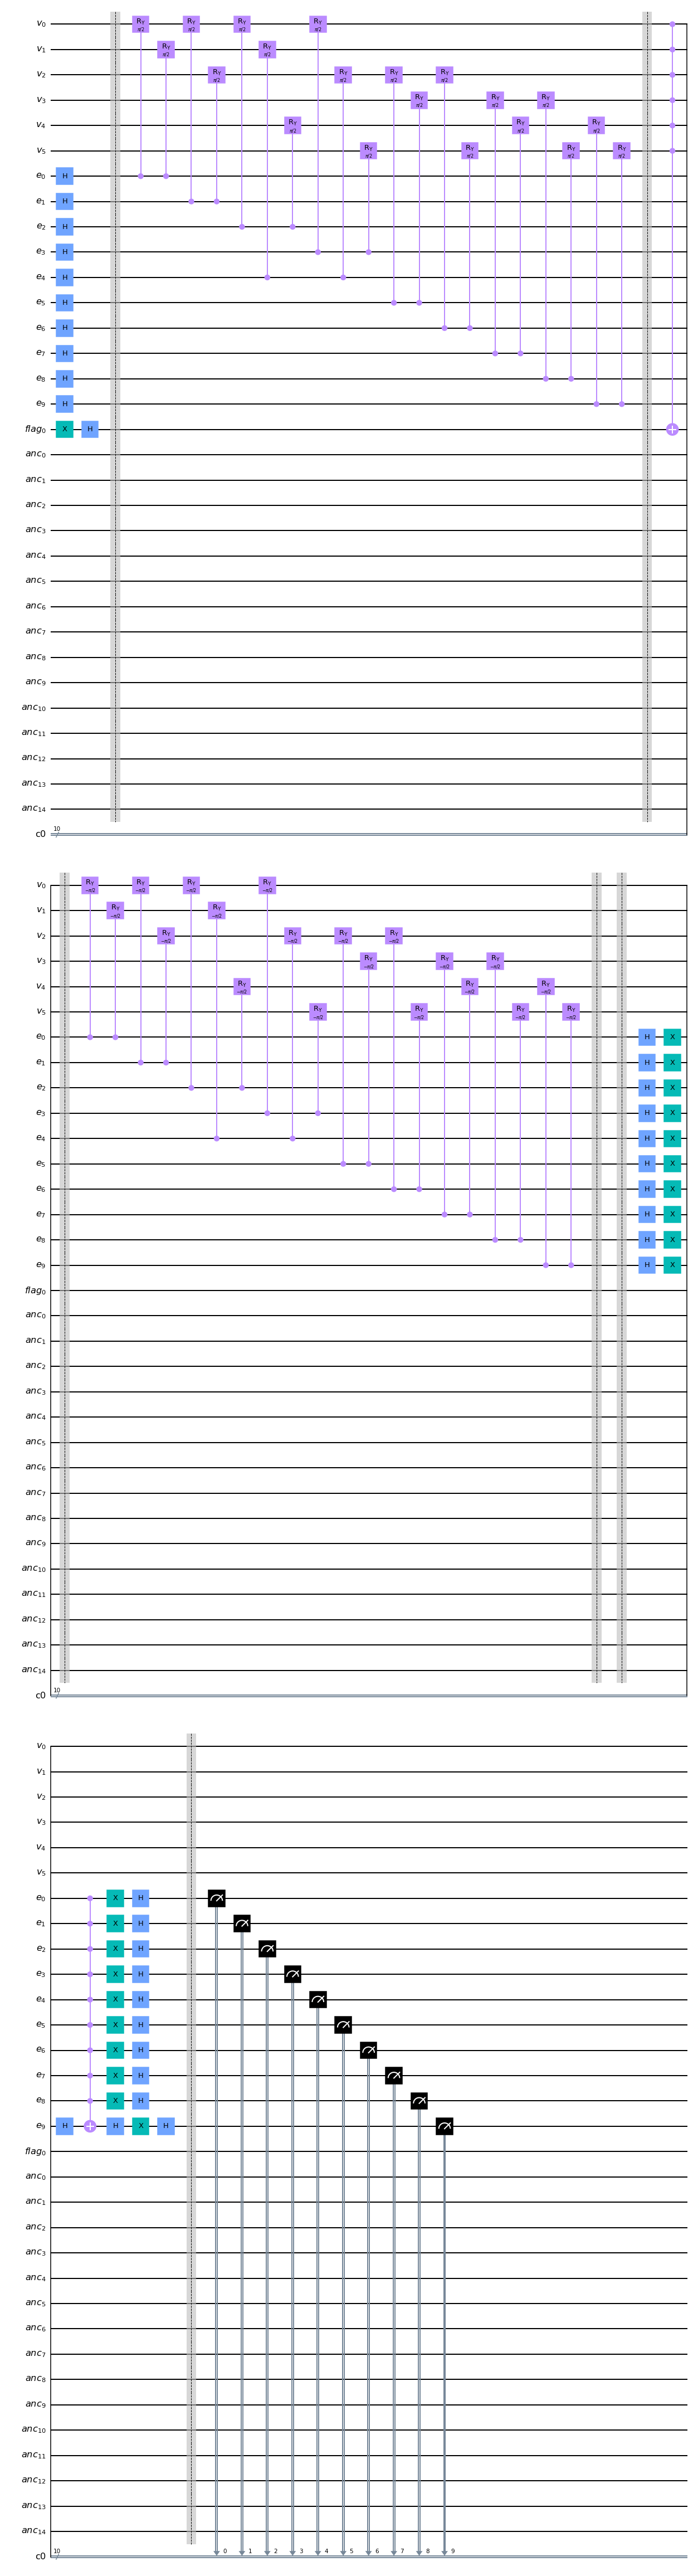

In [6]:
v = QuantumRegister(n_vertices, name='v')
e = QuantumRegister(n_edges, name='e')
flag = QuantumRegister(1, name='flag')
n_anc = 32-n_vertices-n_edges-1
anc = QuantumRegister(n_anc, name='anc')

c = ClassicalRegister(n_edges)

qc = QuantumCircuit(v, e, flag, anc, c)

qc.h(e)

qc.x(flag)
qc.h(flag)

qc.barrier()
iter = 1
for _ in range(iter):
    oracle(qc, v, e, flag, n_vertices)
    qc.barrier()
    diffuser(qc, e, anc)
    qc.barrier()


qc.measure(e, c)
qc.draw('mpl')

Corremos la simulación con 5012 disparos.

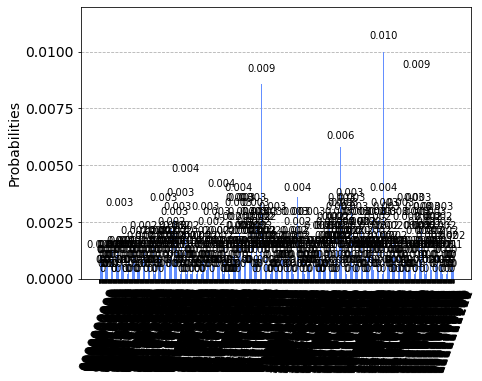

In [8]:
shots = 5012
backend = Aer.get_backend('qasm_simulator')
count = execute(qc, backend=backend, shots=shots).result().get_counts()
plot_histogram(count)

![Key](img/key.png)

El algoritmo filtra sub-caminos que no forman el circuito hamiltoniano, por lo que se realiza un postprocesamiento para encontrar el camino hamiltoniano más eficiente.

In [9]:
from collections import defaultdict

class Graph:    

    # Constructor
    def __init__(self):

        # default dictionary to store graph
        self.graph = defaultdict(list)

    # function to add an edge to graph
    def addEdge(self,u,v):
        self.graph[u].append(v)
        self.graph[v].append(u)

    # Function to print a BFS of graph
    def BFS(self, s):

        # Mark all the vertices as not visited
        visited = [False] * (max(self.graph) + 1)

        # Create a queue for BFS
        queue = []
        count = 0

        # Mark the source node as
        # visited and enqueue it
        queue.append(s)
        visited[s] = True
        count += 1

        while queue:

            # Dequeue a vertex from
            # queue and print it
            s = queue.pop(0)

            # Get all adjacent vertices of the
            # dequeued vertex s. If a adjacent
            # has not been visited, then mark it
            # visited and enqueue it
            for i in self.graph[s]:
                if visited[i] == False:
                    queue.append(i)
                    visited[i] = True
                    count += 1
        return count

def postprocess(count, g_dict, n_vertices):
    sorted_count = {k: t for k, t in sorted(count.items(), key=lambda item: item[1], reverse=True)}
    m = max(sorted_count.values())
    filtered_count = {}
    for k in sorted_count:
        if sorted_count[k] > m/2+1:
            filtered_count[k] = sorted_count[k]
        else:
            break
    answer = []
    for k in filtered_count.keys():
        g = Graph()
        for i, v in enumerate(k[::-1]):
            if v == '1':
                g.addEdge(g_dict[i][0], g_dict[i][1])
        if g.BFS(0) == n_vertices:
            answer.append(k)
    return answer

In [10]:
postprocess(count, g_dict, n_vertices)

['1100110101', '0111010101', '1010111001']

Después del procesado, encontramos el camino hamiltoniano resultante:

![Result](img/result_.png)